In [1]:
import pandas as pd
import numpy as np

import random
import string
from tqdm import tqdm

import gensim
from gensim import utils

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis




import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

tqdm.pandas(desc='progress-bar')

Using TensorFlow backend.


In [2]:
df_bills = pd.read_csv('data/bill_all.csv')
print(df_bills.columns)
df_bills.tail()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'index', 'Unnamed: 0.1.1.1.1', 'action_date', 'action_time', 'chamber',
       'congress', 'legis_num', 'majority', 'name', 'party', 'role',
       'rollcall_num', 'session', 'state', 'vote', 'vote_desc',
       'vote_question', 'vote_result', 'vote_type', 'link', 'billText',
       'sponsor', 'sponsor_id', 'sponsor_party', 'sponsor_state',
       'sponsor_uri'],
      dtype='object')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,index,Unnamed: 0.1.1.1.1,action_date,action_time,chamber,congress,...,vote_question,vote_result,vote_type,link,billText,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
4057,4057,4057,4057,4057,5158792,5158792,13-Dec-2011,6:59 PM,U.S. House of Representatives,112,...,On Motion to Suspend the Rules and Pass,Passed,2/3 RECORDED VOTE,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,John W. Olver,O000085,D,MA,https://api.propublica.org/congress/v1/members...
4058,4058,4058,4058,4058,5160455,5160455,14-Dec-2011,6:17 PM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,congressional bills 112th congress u.s governm...,Ileana Ros-Lehtinen,R000435,R,FL,https://api.propublica.org/congress/v1/members...
4059,4059,4059,4059,4059,5161291,5161291,14-Dec-2011,6:31 PM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,Stephen Fincher,F000458,R,TN,https://api.propublica.org/congress/v1/members...
4060,4060,4060,4060,4060,5165452,5165452,16-Dec-2011,11:54 AM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 RECORDED VOTE,https://www.congress.gov/bill/112th-congress/h...,congressional bills 112th congress u.s governm...,Mark Udall,U000038,D,CO,https://api.propublica.org/congress/v1/members...
4061,4061,4061,4061,4061,5166702,5166702,16-Dec-2011,2:04 PM,U.S. House of Representatives,112,...,On Passage,Passed,YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,Harold Rogers,R000395,R,KY,https://api.propublica.org/congress/v1/members...


In [3]:
print(df_bills['sponsor'].unique().size)

841


In [4]:
df_votes = pd.read_csv('data/votes_all.csv')
print(df_votes.columns)
df_votes.tail()

Index(['Unnamed: 0', 'action_date', 'action_time', 'chamber', 'congress',
       'legis_num', 'majority', 'name', 'party', 'role', 'rollcall_num',
       'session', 'state', 'vote', 'vote_desc', 'vote_question', 'vote_result',
       'vote_type'],
      dtype='object')


,Unnamed: 0,action_date,action_time,chamber,congress,legis_num,majority,name,party,role,rollcall_num,session,state,vote,vote_desc,vote_question,vote_result,vote_type
5169626,5169626,20-Dec-2011,4:16 PM,U.S. House of Representatives,112,H RES 501,R,Woodall,R,legislator,949,1st,GA,Yea,Expressing the sense of the House of Represent...,On Agreeing to the Resolution,Passed,YEA-AND-NAY
5169627,5169627,20-Dec-2011,4:16 PM,U.S. House of Representatives,112,H RES 501,R,Yoder,R,legislator,949,1st,KS,Yea,Expressing the sense of the House of Represent...,On Agreeing to the Resolution,Passed,YEA-AND-NAY
5169628,5169628,20-Dec-2011,4:16 PM,U.S. House of Representatives,112,H RES 501,R,Young (AK),R,legislator,949,1st,AK,Yea,Expressing the sense of the House of Represent...,On Agreeing to the Resolution,Passed,YEA-AND-NAY
5169629,5169629,20-Dec-2011,4:16 PM,U.S. House of Representatives,112,H RES 501,R,Young (FL),R,legislator,949,1st,FL,Yea,Expressing the sense of the House of Represent...,On Agreeing to the Resolution,Passed,YEA-AND-NAY
5169630,5169630,20-Dec-2011,4:16 PM,U.S. House of Representatives,112,H RES 501,R,Young (IN),R,legislator,949,1st,IN,Yea,Expressing the sense of the House of Represent...,On Agreeing to the Resolution,Passed,YEA-AND-NAY


In [5]:
df_votes.tail()
# print(df_votes[1])

df_votes = df_votes[df_votes['legis_num'] != 'ADJOURN']

df_list = []
for name, group in tqdm(df_votes.groupby('legis_num')):
#     print('Bill', name)
#     print('vote shape', group.shape)
    bill = df_bills[df_bills['legis_num'] == name]
    group.reset_index(inplace=True)
#     print( bill['sponsor'])
    group['sponsor'] = bill.iloc[0]['sponsor']
    group['sponsor_id'] = bill.iloc[0]['sponsor_id']
    group['sponsor_party'] = bill.iloc[0]['sponsor_party']
    group['sponsor_state'] = bill.iloc[0]['sponsor_state']
    group['sponsor_uri'] = bill.iloc[0]['sponsor_uri']
    df_list.append(group)
#     print(group.columns)
#     break
    
df_final = pd.concat(df_list)

df_final.reset_index(inplace=True)
df_final.to_csv('data/df_vote_final.csv')
df_final.head()


  0%|          | 0/4061 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

,level_0,index,Unnamed: 0,action_date,action_time,chamber,congress,legis_num,majority,name,...,vote,vote_desc,vote_question,vote_result,vote_type,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
0,0,370576,370576,17-Apr-2007,6:52 PM,U.S. House of Representatives,110,H CON RES 100,D,Abercrombie,...,Yea,Condemning the recent violent actions of the G...,"On Motion to Suspend the Rules and Agree, as A...",Passed,2/3 YEA-AND-NAY,Tom Lantos,L000090,D,CA,https://api.propublica.org/congress/v1/members...
1,1,370577,370577,17-Apr-2007,6:52 PM,U.S. House of Representatives,110,H CON RES 100,D,Ackerman,...,Yea,Condemning the recent violent actions of the G...,"On Motion to Suspend the Rules and Agree, as A...",Passed,2/3 YEA-AND-NAY,Tom Lantos,L000090,D,CA,https://api.propublica.org/congress/v1/members...
2,2,370578,370578,17-Apr-2007,6:52 PM,U.S. House of Representatives,110,H CON RES 100,D,Aderholt,...,Yea,Condemning the recent violent actions of the G...,"On Motion to Suspend the Rules and Agree, as A...",Passed,2/3 YEA-AND-NAY,Tom Lantos,L000090,D,CA,https://api.propublica.org/congress/v1/members...
3,3,370579,370579,17-Apr-2007,6:52 PM,U.S. House of Representatives,110,H CON RES 100,D,Akin,...,Yea,Condemning the recent violent actions of the G...,"On Motion to Suspend the Rules and Agree, as A...",Passed,2/3 YEA-AND-NAY,Tom Lantos,L000090,D,CA,https://api.propublica.org/congress/v1/members...
4,4,370580,370580,17-Apr-2007,6:52 PM,U.S. House of Representatives,110,H CON RES 100,D,Alexander,...,Yea,Condemning the recent violent actions of the G...,"On Motion to Suspend the Rules and Agree, as A...",Passed,2/3 YEA-AND-NAY,Tom Lantos,L000090,D,CA,https://api.propublica.org/congress/v1/members...


In [6]:
df_final = pd.read_csv('data/df_vote_final.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_final['sponsor'].unique()

array(['Tom Lantos', 'James A. Leach', 'Jan Schakowsky',
       'Duncan L. Hunter', 'Colleen Hanabusa', 'Gerald E. Connolly',
       'Louise M. Slaughter', 'Scott Garrett', 'Carolyn McCarthy',
       'Jeffrey Denham', 'Eleanor Holmes Norton', 'Christopher H. Smith',
       'Glenn Thompson', 'Diane Watson', 'Mary Bono Mack',
       'Ileana Ros-Lehtinen', 'Harold E. Ford Jr.', 'Dan Lungren',
       'Michael Arcuri', 'John Lewis', 'Elijah E. Cummings',
       'Doug Lamborn', 'Robert William Ney', 'Jack Kingston',
       'Eliot L. Engel', 'Henry E. Brown Jr.', 'Edward J. Markey',
       'Edward Royce', 'Michael Allen Collins', 'Henry John Hyde',
       'David E. Price', 'Johnny Isakson', 'Patrick J. Murphy',
       'J.C. Watts', 'Jim McGovern', 'Juanita Millender-McDonald',
       'David Vitter', 'Rob Woodall', 'Mark A. Green', 'Tom Udall',
       'Charles B. Rangel', 'Todd R. Platts', 'Charles W. Norwood',
       'Lou Barletta', 'Judy Biggert', 'Nathan Deal', 'Tim Walz',
       'Rahm Eman

In [8]:
df_final = df_final.dropna(subset=['sponsor'])
df_final['vote_desc'].replace(np.nan, '', regex=True)
# df_final.reset_index(inplace=True)
df_final.tail()

,Unnamed: 0,level_0,index,Unnamed: 0.1,action_date,action_time,chamber,congress,legis_num,majority,...,vote,vote_desc,vote_question,vote_result,vote_type,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
5103690,5103690,413,2835512,2835512,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103691,5103691,414,2835513,2835513,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103692,5103692,415,2835514,2835514,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103693,5103693,416,2835515,2835515,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103694,5103694,417,2835516,2835516,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing congress 106
congress shape (231971, 26)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

       sponsor_id  sponsor_party  sponsor_state
48752          83              0             36
[1]
X shape (231971, 3)
y shape (231971,)
X_train (173978, 3) y_train (173978,)
X_test (57993, 3) y_test (57993,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model_mse 0.2991223078647423
accuracy 0.7008776921352577
[[  514 17007]
 [  340 40132]]
             precision    recall  f1-score   support

        Nay       0.60      0.03      0.06     17521
        Yea       0.70      0.99      0.82     40472

avg / total       0.67      0.70      0.59     57993

Yea    161316
Nay     70655
Name: vote, dtype: int64


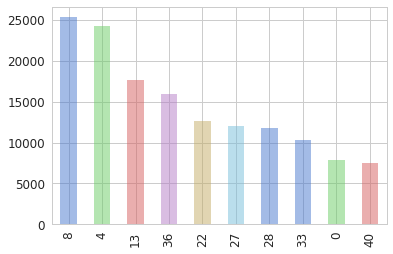

In [9]:
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
encoder = FeatureHasher(n_features=10, input_type="string")
encoder = preprocessing.LabelEncoder()

feature_all = {}
y_all = {}

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
n_components = 20
    
for name, group in tqdm(df_final.groupby('congress')):
    print('Processing congress', name)
    print('congress shape', group.shape)  
    
#     print(encoder.fit_transform(group[['sponsor_id', 'sponsor_party', 'sponsor_state']]).shape)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=10000,
                                   stop_words='english')

    
    group['sponsor_id'] = encoder.fit_transform(group['sponsor_id'])
    group['sponsor_party'] = encoder.fit_transform(group['sponsor_party'])
    group['sponsor_state'] = encoder.fit_transform(group['sponsor_state'])
#     tf_idf_desc = tfidf_vectorizer.fit_transform(group['vote_desc'].values.astype('U'))
#     print('tf_idf shape', tf_idf_desc.shape)
#     nmf = NMF(n_components=n_components, 
#               random_state=1, beta_loss='kullback-leibler', 
#               solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5).fit_transform(tf_idf_desc)
#     print('nmf shape', nmf.shape)

    X = group[['sponsor_id', 'sponsor_party', 'sponsor_state']]
#     print(X)
#     X = np.hstack((group['sponsor_id'].values.reshape(-1,1), 
#                    group['sponsor_party'].values.reshape(-1,1), 
#                    group['sponsor_state'].values.reshape(-1,1)))
    

#     X = np.hstack((encoder.fit_transform(group['sponsor_id']).reshape(-1,1), 
#                    encoder.fit_transform(group['sponsor_party']).reshape(-1,1), 
#                    encoder.fit_transform(group['sponsor_state']).reshape(-1,1)))
#     X = pd.DataFrame(X)
#     print(X.describe())
#     print(list(encoder.classes_))

    y = group['vote']
    le = preprocessing.LabelEncoder()
    le.fit(y)
#     print(le.classes_)
    y = le.transform(y)
    print(X[:1])
    print(y[:1])

    print('X shape', X.shape)
    print('y shape', y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

    print('X_train', X_train.shape, 'y_train', y_train.shape)
    print('X_test', X_test.shape, 'y_test', y_test.shape)
    
    clf = DummyClassifier(strategy="most_frequent")
#     clf = SVC(kernel="linear", C=0.025)
#     clf = MLPClassifier(alpha=1)
#     clf = AdaBoostClassifier()
#     clf = GaussianProcessClassifier(1.0 * RBF(1.0))
#     clf = DecisionTreeClassifier(max_depth=5)
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
#     clf = KNeighborsClassifier(3)
#     clf = GaussianNB()
    print(clf)

    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)

    regression_model_mse = mean_squared_error(y_test, y_predict)
    print('model_mse', regression_model_mse)
    print('accuracy', accuracy_score(y_test, y_predict))

    print(confusion_matrix(y_test, y_predict))
    print(classification_report(y_test, y_predict, target_names=le.classes_))
    
    print((group['vote'].value_counts()))
#     group['vote'].value_counts().plot(kind='bar', alpha=.5)
    group['sponsor_state'].value_counts()[:10].plot(kind='bar', alpha=.5)
             
    break



110    879
111    672
108    414
109    364
107    354
114    346
113    324
112    286
115    256
106    167
Name: congress, dtype: int64


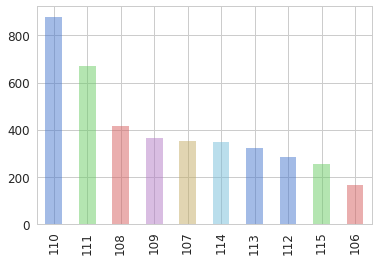

In [10]:
print((df_bills['congress'].value_counts()))
df_bills['congress'].value_counts().plot(kind='bar', alpha=.5)

Yea    3322373
Nay    1781322
Name: vote, dtype: int64


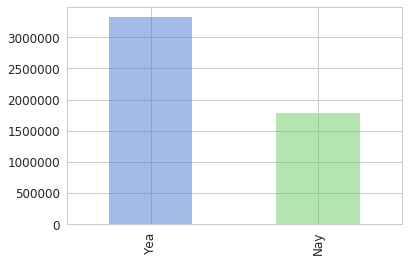

In [11]:
print((df_votes['vote'].value_counts()))
df_votes['vote'].value_counts().plot(kind='bar', alpha=.5)

Passed       2977052
Failed       1595127
Agreed to     531516
Name: vote_result, dtype: int64


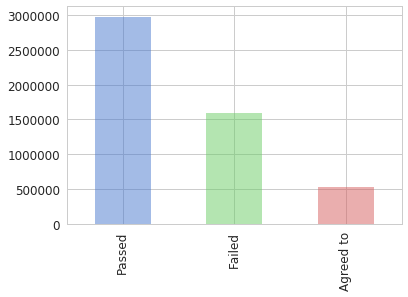

In [12]:
print((df_votes['vote_result'].value_counts()))
df_votes['vote_result'].value_counts().plot(kind='bar', alpha=.5)

# Creat Vote Matrix and Bill representation

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/home/sonic/.keras/datasets/GoogleNews-vectors-negative300.bin',
                                                        binary=True)


In [ ]:
  
max_words = 20000
MAX_SEQUENCE_LENGTH = 10000
def process_doc(X):
    tokenizer = Tokenizer(num_words=max_words,lower=True, split=' ', 
                          filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                          char_level=False, oov_token=u'<UNK>')

    tokenizer.fit_on_texts(X)

    X_seq = tokenizer.texts_to_sequences(X)

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X)

    tf_transformer = TfidfTransformer().fit(X_train_counts)
    X_train_tf = tf_transformer.transform(X_train_counts)

    x_emb =[]
    for doc in X: #look up each doc in model
        x_emb.append(document_vector(model, doc))


    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

#     X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,  padding="post", truncating="post")
    return np.array(X_seq), word_index, np.array(x_emb), X_train_tf, X_train_counts

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)


def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

In [ ]:
%%time


AYE = 1
NAY = -1

vote_matrix_all = {}
X_seq_all = {}
word_index_all = {}
X_train_tf_all = {}
X_train_counts_all = {}
X_emb_all = {}
legistlator_dict_all = {}


grouped_congress = df_bills.groupby('congress')


for name, group in grouped_congress:
    print('Processing congress', name)
    print('congress shape', group.shape)
    
    df_votes_filtered = df_votes[df_votes['congress'] == name]
    
    num_legistlators = len(df_votes_filtered['name'].unique())
    print('number of legistlators', num_legistlators)
    vote_matrix = np.zeros((group.shape[0], num_legistlators))
    print('vote_matrix.shape', vote_matrix.shape)
    
    # Creat legistor dict mapping!
    legistlator_dict = {}
    i = 0
    for legitslator in df_votes_filtered['name'].unique():
        legistlator_dict[legitslator] = i
        i += 1
    
    legistlator_dict_all[name] = {v: k for k, v in legistlator_dict.items()} 
    
#     print(legistlator_dict)
    print('Processing congress votes')
    group.reset_index(inplace=True)
    
    vote_feature = []
    # Process Vote matrix here
    for index, row in tqdm(group.iterrows()):
        
        df_filtered = df_votes_filtered[df_votes_filtered['legis_num'] == row['legis_num']]

        for _, vote in df_filtered.iterrows():
            if vote['vote'] == 'Yea':
                vote_matrix[index, legistlator_dict[vote['name']]] = AYE
            elif vote['vote'] == 'Nay':
                vote_matrix[index, legistlator_dict[vote['name']]] = NAY

    # Process bill Representation Here
    print('processing congress bills')
    X_seq, word_index, x_emb, X_train_tf, X_train_counts = process_doc(group['billText'].apply(str))

    vote_matrix_all[name] = vote_matrix
    X_seq_all[name] = X_seq
    word_index_all[name] = word_index
    X_emb_all[name] = x_emb
    X_train_tf_all[name] = X_train_tf
    X_train_counts_all[name] = X_train_counts
    
    print('*' * 50)
#     break
    
# print('feature_all', feature_all[106].shape)
# print('y_all', y_all[106].shape)
   
print('vote_matrix_all.shape', vote_matrix_all[106].shape)
np.save('data/vote_matrix_all.npy', vote_matrix_all)
np.save('data/X_seq_all.npy', X_seq_all)
np.save('data/X_word_index_all.npy', word_index_all)
np.save('data/X_train_tf_all.npy', X_train_tf_all)
np.save('data/X_train_counts_all.npy', X_train_counts_all)
np.save('data/X_emb_all.npy', X_emb_all)
np.save('data/legistlator_all.npy', legistlator_dict_all)


In [ ]:

vo_df = df_votes.concat(df_bills, on='legis_num')

In [ ]:
vote_train = {}
for name, group in df_votes.groupby('congress'):
    print('Processing congress', name)
    print('congress shape', group.shape)
    vote
    
#     vote_train[name] = group[['majority', 'party', 'sponser', 'vote_result', 'vote', ]]
    
    break

# vote_train[106].tail()

In [ ]:
print(vote_matrix_all[106].shape)
print(X_seq_all[106].shape)
# print(word_index_all[106].shape)
print(X_train_tf_all[106].shape)
print(X_train_counts_all[106].shape)
print(X_emb_all[106].shape)

In [ ]:
congress = 115
x = X_emb_all[congress]
print('x', x.shape)
df_congress = df_bills[df_bills['congress'] == congress]
y = df_congress['party'].values
print(y.shape)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
print(le.classes_)
y = le.transform(y)
print(y)

colors = ['blue', 'red']

In [ ]:
# Pretty Useless :) 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

plt.figure(1, figsize=(20, 20),)
plt.scatter(x_pca[:, 0], x_pca[:, 1], s=100, c=y, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.6)


In [ ]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, verbose=2).fit_transform(x)

plt.figure(1, figsize=(20, 20),)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=100, c=y, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.6)